In [1]:
import pandas as pd
import os
import torch
import numpy as np
from torch.utils.data import DataLoader
from steams.data.KVyQVx import KVyQVx
from steams.models.mads import madsnn2
from steams.tepe.steams import attention_steams
from steams.tepe.tepe import train, evaluation, prediction_prime, ensemble_prime
from steams.utils.criterion import R2,RMSE,variance
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

In [2]:
parent_dir = os.path.abspath(os.path.join(os.path.abspath(os.getcwd()), os.pardir))

In [3]:
resdir = os.path.join(parent_dir,'results')
figdir = os.path.join(parent_dir,'fig')
if not os.path.exists(figdir):
    os.makedirs(figdir)
if not os.path.exists(resdir):
    os.makedirs(resdir)

In [4]:
if torch.cuda.is_available():
    cuda_name = "1"
    num_workers=0
    pin_memory = True
    device = torch.device('cuda'+":"+cuda_name)
    #device = torch.device('cuda')
else:
    num_workers = 0
    pin_memory = False
    device = torch.device('cpu')

In [5]:
device

device(type='cpu')

## train/valid dataset

In [6]:
params = {
        "class" : "KVyQVx",
        "Y":{
          "path": "",
          "KEY":["x","y","rmse","variance"],
          "VALUE": ["value"],
          "nb_location" : 6000,
          "history_length": 0,
          "nb_sampling": 100
        },
        "X":{
          "path": "",
          "QUERY":["x","y",'rmse_ref','variance_ref'],
          "VALUE": ["ref"],
          "nb_location" : 6000,
          "gap_length": 0,
          "horizon_length":0,
          "nb_sampling": 100
        }
    }

In [7]:
params['Y']['path'] = os.path.join(parent_dir,"session","synth_1000_Y_train_6s")
params['X']['path'] = os.path.join(parent_dir,"session","synth_1000_X_train_6s")

train_dataset = KVyQVx(params)

In [8]:
params['Y']['path'] = os.path.join(parent_dir,"session","synth_1000_Y_valid_6s")
params['X']['path'] = os.path.join(parent_dir,"session","synth_1000_X_valid_6s")

valid_dataset = KVyQVx(params)

In [9]:
#train_dataset[0]

## model, optimizer, criterion, scheduler

In [10]:
#model
model = madsnn2(device,type="nwd",kernel="gauss", input_k=4,input_q=4, input_v=1, hidden_size=32)

In [11]:
# optimzer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3) #8e-3
#optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

# criterion
criterion = torch.nn.MSELoss()

# steams object
obj = attention_steams(model,device)
obj.init_optimizer(optimizer)
obj.init_criterion(criterion)

## Training

In [12]:
# training
train(obj,train_dataset,valid_dataset,niter=50,n_iter_stop=20,batch_size=1,shuffle=True,num_workers=num_workers,pin_memory=pin_memory,resdir=None)

  epoch     train     valid
0     0  0.228183  0.111863
  epoch     train     valid
0     1  0.157266  0.097938
  epoch     train     valid
0     2  0.146501  0.089466
  epoch    train    valid
0     3  0.13809  0.09329
  epoch     train     valid
0     4  0.133166  0.085698
  epoch     train     valid
0     5  0.129395  0.080848
  epoch     train     valid
0     6  0.129428  0.085766
  epoch     train    valid
0     7  0.128253  0.07455
  epoch     train     valid
0     8  0.126326  0.080008
  epoch     train     valid
0     9  0.126369  0.083211
  epoch    train     valid
0    10  0.12543  0.082054
  epoch     train     valid
0    11  0.124415  0.074803
  epoch     train     valid
0    12  0.124966  0.065376
  epoch     train   valid
0    13  0.122805  0.0715
  epoch     train     valid
0    14  0.123156  0.073005
  epoch     train     valid
0    15  0.122305  0.074673
  epoch     train     valid
0    16  0.122118  0.070532
  epoch     train     valid
0    17  0.121276  0.071761
  ep

In [13]:
obj.save_model(res_dir,"3d-nwdnn2")

## Evaluation

In [14]:
params['Y']['path'] = os.path.join(parent_dir,"session","synth_1000_Y_eval_6s")
params['X']['path'] = os.path.join(parent_dir,"session","synth_1000_X_eval_6s")

eval_dataset = KVyQVx(params)

In [15]:
criterion = R2()
#criterion = torch.nn.MSELoss()
obj.init_criterion(criterion)

In [16]:
evaluation(obj,eval_dataset,batch_size=1,shuffle=True,num_workers=num_workers,pin_memory=pin_memory,resdir=None)

0.8939400852024555


In [17]:
criterion = RMSE()
obj.init_criterion(criterion)

In [18]:
evaluation(obj,eval_dataset,batch_size=1,shuffle=True,num_workers=num_workers,pin_memory=pin_memory,resdir=None)

0.13714241488650442


In [19]:
criterion = variance()
obj.init_criterion(criterion)

In [20]:
evaluation(obj,eval_dataset,batch_size=1,shuffle=True,num_workers=num_workers,pin_memory=pin_memory,resdir=None)

0.01187712586321868


## QQplot

In [21]:
params['Y']['path'] = os.path.join(parent_dir,"session","synth_1000_Y_eval_6s")
params['X']['path'] = os.path.join(parent_dir,"session","synth_1000_X_eval_6s")

eval_dataset = KVyQVx(params)

In [22]:
results = prediction_prime(obj,eval_dataset)

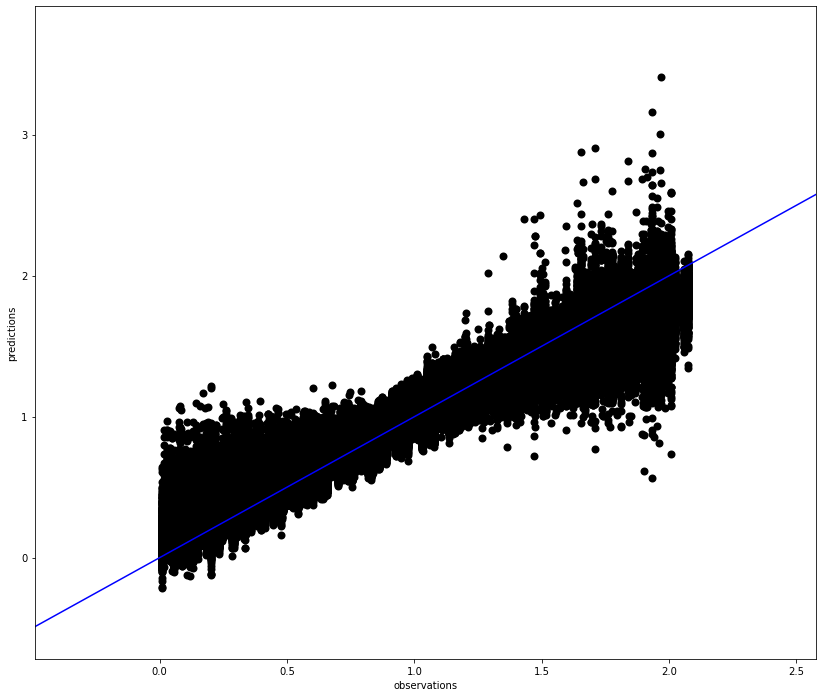

In [23]:
pred_name = ['pred_' + v for v in eval_dataset.VALUE_X]

fig, ax= plt.subplots(figsize=(14, 12))
ax.scatter(results.loc[:,eval_dataset.VALUE_X],results.loc[:,pred_name], linewidth=2.0,c="black")
ax.axline((0, 0), slope=1., color='blue')
ax.set_xlim(results.loc[:,"ref"].min().item()-0.5, results.loc[:,"ref"].max().item()+0.5)
ax.set_ylim(results.loc[:,pred_name].min().item()-0.5, results.loc[:,pred_name].max().item()+0.5)
ax.set(xlabel='observations', ylabel='predictions')

fig_filename = os.path.join(parent_dir,'fig','3d-qqplot.png')
plt.savefig(fig_filename, dpi = 300)

## Illustration of Wq on a map

In [24]:
params['Y']['path'] = os.path.join(parent_dir,"session","synth_1000_Y_eval_6s")
params['X']['path'] = os.path.join(parent_dir,"session","synth_all_6400_6s")
params['X']['nb_location'] = 6400

eval_dataset = KVyQVx(params)

In [25]:
eval_dataset.scale(True)
obj.model.eval()
with torch.no_grad():
    results = pd.DataFrame(columns=['x','y','rmse','variance','Wqx','Wqy','Wqrmse','Wqvariance','Wo'])
    obs=[]
    pred=[]
    for i in range(len(eval_dataset)):
        
        KEY_Y,VALUE_Y,QUERY_X, VALUE_X = eval_dataset[i]
        QUERY_X = QUERY_X.to(obj.device)
    
        # input with dimension batch and on device
        QUERY_X = torch.reshape(QUERY_X,(1,QUERY_X.shape[0],QUERY_X.shape[1]))
        
        W = obj.model.W(QUERY_X.float() ).detach().cpu().numpy()
        
        Wo = obj.model.Wo(QUERY_X.float() ).detach().cpu().numpy()
        QUERY_X_unscaled = eval_dataset.unscale(QUERY_X.detach(),"QUERY")
        
        tmp = np.concatenate((QUERY_X_unscaled, W,Wo),2)
        tmp = np.reshape(tmp,(tmp.shape[1],tmp.shape[2]))
        
        
        tmp_df = pd.DataFrame(tmp,columns=['x','y','rmse','variance','Wqx','Wqy','Wqrmse','Wqvariance','Wo'])
        
        results = results.append(tmp_df,ignore_index=True)
eval_dataset.scale(False)        

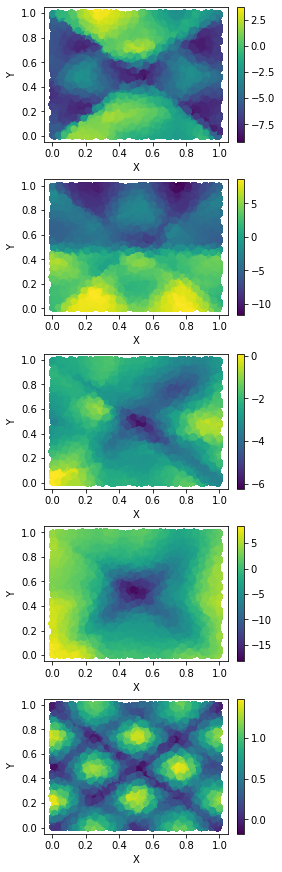

In [26]:
fig = plt.figure(constrained_layout=True,figsize=(14, 12))
gs = GridSpec(5, 5, figure=fig)

ax0 = fig.add_subplot(gs[0,0])
c0 = ax0.scatter(x=results["x"], y=results["y"], c=results["Wqx"], vmax=np.max(results["Wqx"]))
ax0.set(ylabel='Y',xlabel='X')

ax1 = fig.add_subplot(gs[1,0])
c1 = ax1.scatter(x=results["x"], y=results["y"], c=results["Wqy"], vmax=np.max(results["Wqy"]))
ax1.set(ylabel='Y',xlabel='X')

ax2 = fig.add_subplot(gs[2,0])
c2 = ax2.scatter(x=results["x"], y=results["y"], c=results["Wqrmse"], vmax=np.max(results["Wqrmse"]))
ax2.set(ylabel='Y',xlabel='X')

ax3 = fig.add_subplot(gs[3,0])
c3 = ax3.scatter(x=results["x"], y=results["y"], c=results["Wqvariance"], vmax=np.max(results["Wqvariance"]))
ax3.set(ylabel='Y',xlabel='X')

ax4 = fig.add_subplot(gs[4,0])
c4 = ax4.scatter(x=results["x"], y=results["y"], c=results["Wo"], vmax=np.max(results["Wo"]))
ax4.set(ylabel='Y',xlabel='X')


fig.colorbar(c0, ax=ax0)
fig.colorbar(c1, ax=ax1)
fig.colorbar(c2, ax=ax2)
fig.colorbar(c3, ax=ax3)
fig.colorbar(c4, ax=ax4)

fig_filename = os.path.join(parent_dir,'fig','3d-illustration_W.png')
plt.savefig(fig_filename, dpi = 300)


## ensemble, quantiles and p-value 

In [27]:
params['Y']['path'] = os.path.join(parent_dir,"session","synth_1000_Y_eval_6s")
params['X']['path'] = os.path.join(parent_dir,"session","synth_1000_X_eval_6s")

eval_dataset = KVyQVx(params)

In [28]:
# !! might take some time
ensemble = ensemble_prime(obj,eval_dataset,N=2)

In [29]:
ensemble.to_csv(os.path.join(resdir,'3d-ensemble.csv'))

### metrics

In [30]:
obs = torch.tensor(ensemble[('ref', 'mean')].to_numpy())
obs = torch.reshape(obs,(1,obs.shape[0],1))
q0_5 = torch.tensor(ensemble[('pred_ref','q0_5')].to_numpy())
q0_5 = torch.reshape(q0_5,(1,q0_5.shape[0],1))

In [31]:
criterion = R2()
criterion(obs,q0_5)

tensor(0.9237)

In [32]:
criterion = RMSE()
criterion(obs,q0_5)

tensor(0.1180)

In [33]:
criterion = variance()
criterion(obs,q0_5)

tensor(0.0097)

### qqplot of the observation against the median of the ensemble at each location

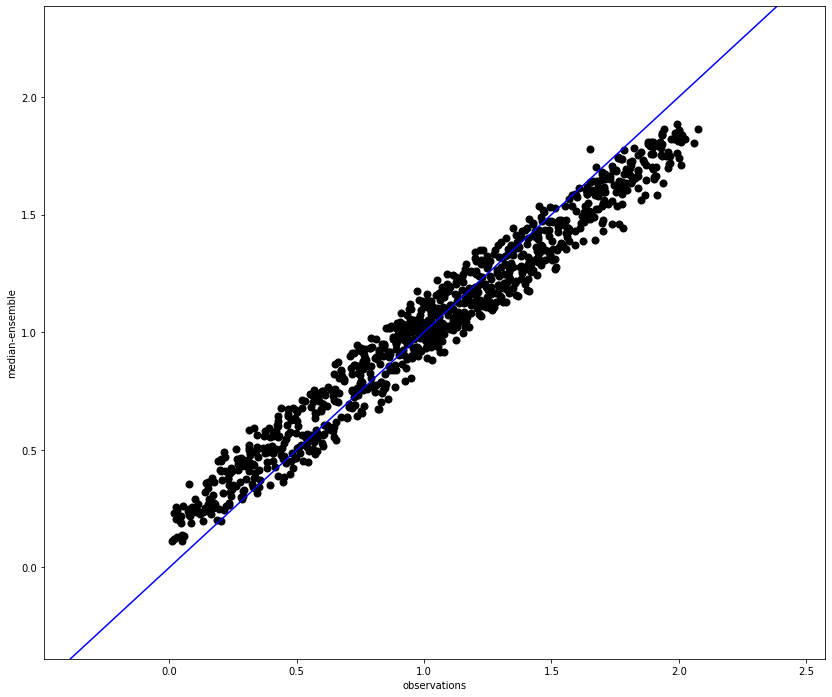

In [34]:
fig, ax= plt.subplots(figsize=(14, 12))
ax.scatter(ensemble[('ref', 'mean')],ensemble[('pred_ref','q0_5')], linewidth=2.0,c="black")
ax.axline((0, 0), slope=1., color='blue')
ax.set_xlim(0, 2.5)
ax.set_xlim(ensemble[('ref', 'mean')].min().item()-0.5, ensemble[('ref', 'mean')].max().item()+0.5)
ax.set_ylim(ensemble[('pred_ref','q0_5')].min().item()-0.5, ensemble[('pred_ref','q0_5')].max().item()+0.5)
ax.set(xlabel='observations', ylabel='median-ensemble')

fig_filename = os.path.join(parent_dir,'fig','3d-ensemble_q0_5_qqplot.png')
plt.savefig(fig_filename, dpi = 300)

### p-qqplot of the p-value of the obsevration within its ensemble against an uniform distribution

In [35]:
ensemble = ensemble.sort_values(by='p_ref')
ensemble["U"] = np.linspace(0, 1, num=ensemble.shape[0])    

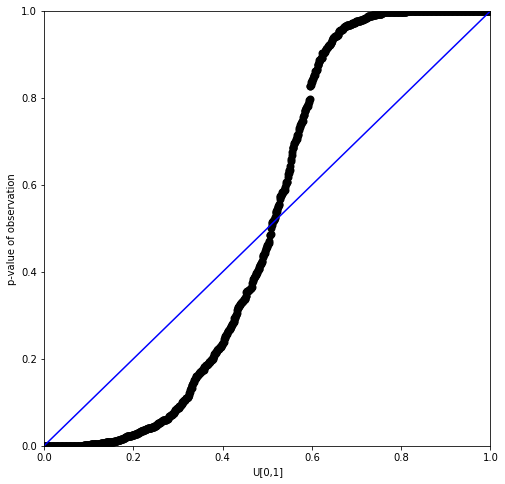

In [36]:
fig, ax= plt.subplots(figsize=(8, 8))
ax.scatter(ensemble['U'],ensemble['p_ref'], linewidth=2.0,c="black")
ax.axline((0, 0), slope=1., color='blue')
ax.set_xlim(0, 1)
ax.set_ylim(0,1)
ax.set(xlabel='U[0,1]', ylabel='p-value of observation')

fig_filename = os.path.join(parent_dir,'fig','3d-p_qqplot.png')
plt.savefig(fig_filename, dpi = 300)

## Illustration of quantile on maps

In [37]:
params['Y']['path'] = os.path.join(parent_dir,"session","synth_1000_Y_eval_6s")
params['X']['path'] = os.path.join(parent_dir,"session","synth_all_6400_6s")
params['X']['nb_location'] = 6400

eval_dataset = KVyQVx(params)

In [38]:
# !! might take some time
ensemble = ensemble_prime(obj,eval_dataset,N=2)

In [39]:
vmax = np.array(
    np.abs(np.array([ensemble[('pred_ref','q0_05')] - ensemble[('pred_ref','q0_5')]])).max(),
    np.array([ensemble[('pred_ref','q0_95')] - ensemble[('pred_ref','q0_5')]]).max()).max()


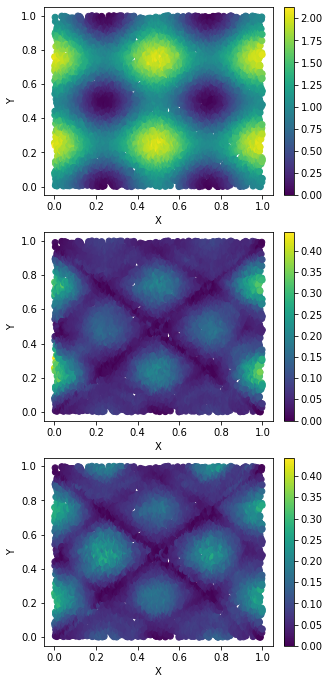

In [40]:
fig = plt.figure(constrained_layout=True,figsize=(14, 12))
gs = GridSpec(4, 4, figure=fig)

ax0 = fig.add_subplot(gs[0,0])
c0 = ax0.scatter(x=ensemble["x"], y=ensemble["y"], c=ensemble[('ref', 'mean')])
ax0.set(ylabel='Y',xlabel='X')

ax1 = fig.add_subplot(gs[1,0])
c1 = ax1.scatter(x=ensemble["x"], y=ensemble["y"], c=np.abs(ensemble[('pred_ref', 'q0_05')]- ensemble[('pred_ref', 'q0_5')]), vmin = 0, vmax=vmax)
ax1.set(ylabel='Y',xlabel='X')

ax2 = fig.add_subplot(gs[2,0])
c2 = ax2.scatter(x=ensemble["x"], y=ensemble["y"], c=ensemble[('pred_ref', 'q0_95')] - ensemble[('pred_ref', 'q0_5')], vmin = 0, vmax=vmax)
ax2.set(ylabel='Y',xlabel='X')


fig.colorbar(c0, ax=ax0)
fig.colorbar(c1, ax=ax1)
fig.colorbar(c2, ax=ax2)

fig_filename = os.path.join(parent_dir,'fig','3d-illustration_diff_median-q005_and_median-q095.png')
plt.savefig(fig_filename, dpi = 300)
